<a href="https://colab.research.google.com/github/mampisarkar111/Matlab/blob/master/wisonet_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WISONet δD Retrievals
This notebook demonstrates how averaging kernels and a priori values affect satellite δD retrievals.


In [4]:
!curl -L "https://rice.box.com/shared/static/bcoy3ob0dme3umpurqmf0p6o48bznkj1" -o SWING3_2006_subset.nc
!curl -L "https://rice.box.com/shared/static/uuy9m15qc1p7s4wm1yrzfzxc6knx7hzw" -o TES_monthly_5deg_strict.nc


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      7      0 --:--:--  0:00:01 --:--:--  8000
100 12.7M  100 12.7M    0     0  6805k      0  0:00:01  0:00:01 --:--:-- 6805k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    10    0    10    0     0      6      0 --:--:--  0:00:01 --:--:-- 10000
100 3095M  100 3095M    0     0  69.7M      0  0:00:44  0:00:44 --:--:-- 72.7M


In [5]:
!ls -lh
!pip install cartopy
import cartopy

total 3.1G
drwxr-xr-x 1 root root 4.0K Jun 11 13:37 sample_data
-rw-r--r-- 1 root root  13M Jun 13 15:42 SWING3_2006_subset.nc
-rw-r--r-- 1 root root 3.1G Jun 13 15:43 TES_monthly_5deg_strict.nc


In [135]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox, HBox
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Load Datasets Once ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")

# === Common Dimensions ===
lon = ds['lon'].values
lat = ds['lat'].values
p = ds['p'].values


# Satellite dimensions
tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p = sat['level'].values
tes_time = sat['time'].values

# === Widget Controls ===
plevel_input   = widgets.BoundedFloatText(value=800, min=200, max=1000, step=10, description='Level [hPa]:')
month_slider = widgets.IntSlider(min=1, max=12, step=1, value=1, description='Month')
log_toggle = widgets.Checkbox(value=True, description='Log X-axis')
step_dropdown = widgets.Dropdown(
    options=['All', 'A priori only', 'Model vs A priori', 'AK-applied only', 'TES vs AK'],
    value='All',
    description='Step View:'
)
ak_toggle = widgets.Checkbox(value=False, description='Show AK Matrix')

lat_min_input = widgets.BoundedFloatText(value=-10, min=-90, max=90, step=1, description='Lat Min:')
lat_max_input = widgets.BoundedFloatText(value=10, min=-90, max=90, step=1, description='Lat Max:')
lon_min_input = widgets.BoundedFloatText(value=-160, min=-180, max=180, step=5, description='Lon Min:')
lon_max_input = widgets.BoundedFloatText(value=-120, min=-180, max=180, step=5, description='Lon Max:')

# === Plot Function ===
def update_plot(month, plevel,log_x, step_view, show_ak, lat_min, lat_max, lon_min, lon_max):
    m = month - 1
    last_day = calendar.monthrange(2006, month)[1]
    user_date_str = f'2006-{month:02d}-{last_day}'
    target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

    dD = ds['dD'].values.astype(float)
    q = ds['q'].values.astype(float)
    dD[dD == -999] = np.nan
    q[q == -999] = np.nan

    lat_mask = (lat >= lat_min) & (lat <= lat_max)

    lon_min_wrapped = (lon_min + 360) % 360
    lon_max_wrapped = (lon_max + 360) % 360

    lon_mask = (lon >= lon_min_wrapped) & (lon <= lon_max_wrapped)


    dD_eq = dD[m, :, lat_mask, :][:, :, lon_mask]
    q_eq  = q[m, :, lat_mask, :][:, :, lon_mask]

    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
    q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

    Rvsmow = 3.1152e-4
    M_air = 28.9647
    M_H2O = 18.01528
    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)




    q_vmr_3d = (q / M_H2O) / ((q / M_H2O) + ((1 - q) / M_air))
    HDO_vmr1_3d = q_vmr_3d * Rvsmow * (1 + dD / 1000)
    HDO_vmr1_3d=HDO_vmr1_3d[m,:,:,:]

    if np.issubdtype(tes_time.dtype, np.datetime64):
        t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
    else:
        base_date = datetime(2000, 1, 1)
        target_days = (target_date - base_date).days
        t_tes = np.argmin(np.abs(tes_time - target_days))

    tes_mask = (tes_lat >= lat_min) & (tes_lat <= lat_max)
    # tes_lon_mask = (tes_lon >= lon_min) & (tes_lon <= lon_max)
    tes_lon_wrapped = (tes_lon + 360) % 360
    tes_lon_mask = (tes_lon_wrapped >= lon_min_wrapped) & (tes_lon_wrapped <= lon_max_wrapped)



    HDO_ret = sat['HDO_vmr'].values[t_tes, :, tes_mask, :][:, :, tes_lon_mask]
    HDO_a   = sat['HDO_ConstraintVector'].values[t_tes, :, tes_mask, :][:, :, tes_lon_mask]
    AK      = sat['AK_HDO'].values[t_tes, :, :, tes_mask, :][:, :, :, tes_lon_mask]



    # === Contour Plot of TES and Model HDO at a given level hPa ===

    # Select pressure level index
    idx_tes = int(np.argmin(np.abs(tes_p - plevel)))
    idx_mod = int(np.argmin(np.abs(p - plevel)))

    # Extract data
    HDO_globe = sat['HDO_vmr'].values[t_tes, idx_tes, :, :]
    HDO_model = HDO_vmr1_3d[idx_mod, :, :]

    # Mask invalid values
    HDO_globe[HDO_globe == -999] = np.nan
    HDO_model[HDO_model == -999] = np.nan

    # Mask invalid values
    HDO_globe[HDO_globe == -999] = np.nan
    HDO_model[HDO_model == -999] = np.nan

    # Use finite values only to compute shared color scale
    combined = np.concatenate([HDO_globe[np.isfinite(HDO_globe)].flatten(),
                              HDO_model[np.isfinite(HDO_model)].flatten()])
    vmin, vmax = np.nanmin(combined), np.nanmax(combined)

    vmin = np.nanpercentile(combined, 1)
    vmax = np.nanpercentile(combined, 99)

    # === TES Plot ===
    plt.figure(figsize=(10, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    levels = np.linspace(vmin, vmax, 21)  # 20 intervals
    cs = ax.contourf(tes_lon, tes_lat, HDO_globe, levels=levels, cmap='viridis', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.3)
    ax.add_patch(plt.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree()))
    plt.colorbar(cs, ax=ax, label='TES HDO VMR')
    ax.set_title(f'TES HDO VMR at ~{plevel} hPa')
    plt.show()


    # === Model Plot ===
    lon_plot = ((lon + 180) % 360) - 180
    sort_idx = np.argsort(lon_plot)
    lon_plot_sorted = lon_plot[sort_idx]
    HDO_model_sorted = HDO_model[:, sort_idx]

    # Plot with sorted lon
    plt.figure(figsize=(10, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.contourf(lon_plot_sorted, lat, HDO_model_sorted, levels=levels, cmap='viridis',vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.3)
    ax.add_patch(plt.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree()))

    plt.colorbar(cs, ax=ax, label='Model Ensemble HDO VMR')
    ax.set_title(f'Model Ensemble HDO VMR at ~{plevel} hPa')
    plt.show()



    HDO_ret[HDO_ret == -999] = np.nan
    HDO_a[HDO_a == -999] = np.nan
    AK[AK == -999] = np.nan

    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)
    HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)
    AK_avg      = np.nanmean(np.nanmean(AK, axis=3), axis=0)

    AK_avg=AK_avg.T

    HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])
    ln_true = np.log(HDO_vmr1_interp)
    ln_apriori = np.log(HDO_a_avg)


    ln_smoothed = ln_apriori + AK_avg @ (ln_true - ln_apriori)
    HDO_recon = np.exp(ln_smoothed)



    # === Profile Plot ===
    plt.figure(figsize=(6, 8))
    if step_view == 'A priori only':
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
    elif step_view == 'Model vs A priori':
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
    elif step_view == 'AK-applied only':
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    elif step_view == 'TES vs AK':
        plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    else:
        plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')




    plt.gca().invert_yaxis()
    plt.xlabel('HDO VMR [mol/mol]')
    plt.ylabel('Pressure [hPa]')
    plt.title(f'TES vs. Model ({lat_min:.0f} to {lat_max:.0f}°N, {user_date_str})')
    plt.ylim(850, 250)
    if log_x:
        plt.xscale('log')
        plt.xlim(1e-7, 1e-5)
    else:
        plt.xlim(0, 4e-6)
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()

    if show_ak:
        plt.figure(figsize=(5, 6))

        for i in range(AK_avg.shape[0]):
            plt.plot(AK_avg[i, :], tes_p, label=f'Row {i}')

        plt.gca().invert_yaxis()
        plt.xlabel('AK Value (dx_est / dx_true)')
        plt.ylabel('Pressure [hPa]')
        plt.title('Averaging Kernel Rows (Retrieved Level Sensitivity)')
        plt.grid(True)

        # Optional: show legend only for a few rows to avoid clutter
        # plt.legend(loc='lower right', fontsize='small', ncol=2)

        plt.tight_layout()
        plt.show()




# === Combine Widgets ===
ui = VBox([
    HBox([plevel_input]),
    HBox([month_slider]),
    HBox([lat_min_input, lat_max_input, lon_min_input, lon_max_input]),
    HBox([log_toggle, step_dropdown, ak_toggle])
])

out = interactive_output(update_plot, {
    'plevel': plevel_input,
    'month': month_slider,
    'log_x': log_toggle,
    'step_view': step_dropdown,
    'show_ak': ak_toggle,
    'lat_min': lat_min_input,
    'lat_max': lat_max_input,
    'lon_min': lon_min_input,
    'lon_max': lon_max_input
})

display(ui, out)

/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)
/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most x

Output()

In [98]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox, HBox
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Load Datasets Once ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")

# === Common Dimensions ===
lon = ds['lon'].values
lat = ds['lat'].values
p = ds['p'].values

def normalize_lon(lon_array):
    return (lon_array + 360) % 360

lon = normalize_lon(lon)

# Satellite dimensions
tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p = sat['level'].values
tes_time = sat['time'].values

# === Widget Controls ===
plevel_input   = widgets.BoundedFloatText(value=800, min=200, max=1000, step=10, description='Level [hPa]:')
month_slider = widgets.IntSlider(min=1, max=12, step=1, value=1, description='Month')
log_toggle = widgets.Checkbox(value=True, description='Log X-axis')
step_dropdown = widgets.Dropdown(
    options=['All', 'A priori only', 'Model vs A priori', 'AK-applied only', 'TES vs AK'],
    value='All',
    description='Step View:'
)
ak_toggle = widgets.Checkbox(value=False, description='Show AK Matrix')

lat_min_input = widgets.BoundedFloatText(value=-5, min=-90, max=90, step=1, description='Lat Min:')
lat_max_input = widgets.BoundedFloatText(value=5, min=-90, max=90, step=1, description='Lat Max:')
lon_min_input = widgets.BoundedFloatText(value=0, min=-180, max=180, step=5, description='Lon Min:')
lon_max_input = widgets.BoundedFloatText(value=20, min=-180, max=180, step=5, description='Lon Max:')

# === Plot Function ===
def update_plot(month, plevel,log_x, step_view, show_ak, lat_min, lat_max, lon_min, lon_max):
    m = month - 1
    last_day = calendar.monthrange(2006, month)[1]
    user_date_str = f'2006-{month:02d}-{last_day}'
    target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

    dD = ds['dD'].values.astype(float)
    q = ds['q'].values.astype(float)
    dD[dD == -999] = np.nan
    q[q == -999] = np.nan

    lat_mask = (lat >= lat_min) & (lat <= lat_max)
    lon_mask = (lon >= lon_min) & (lon <= lon_max)

    dD_eq = dD[m, :, lat_mask, :][:, :, lon_mask]
    q_eq  = q[m, :, lat_mask, :][:, :, lon_mask]

    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
    q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

    Rvsmow = 3.1152e-4
    M_air = 28.9647
    M_H2O = 18.01528
    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)

    q_vmr_3d = (q / M_H2O) / ((q / M_H2O) + ((1 - q) / M_air))
    HDO_vmr1_3d = q_vmr_3d * Rvsmow * (1 + dD / 1000)
    HDO_vmr1_3d=HDO_vmr1_3d[m,:,:,:]

    if np.issubdtype(tes_time.dtype, np.datetime64):
        t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
    else:
        base_date = datetime(2000, 1, 1)
        target_days = (target_date - base_date).days
        t_tes = np.argmin(np.abs(tes_time - target_days))

    tes_mask = (tes_lat >= lat_min) & (tes_lat <= lat_max)
    tes_lon_mask = (tes_lon >= lon_min) & (tes_lon <= lon_max)



    HDO_ret = sat['HDO_vmr'].values[t_tes, :, tes_mask, :][:, :, tes_lon_mask]
    HDO_a   = sat['HDO_ConstraintVector'].values[t_tes, :, tes_mask, :][:, :, tes_lon_mask]
    AK      = sat['AK_HDO'].values[t_tes, :, :, tes_mask, :][:, :, :, tes_lon_mask]



    # === Contour Plot of TES and Model HDO at a given level hPa ===

    # Select pressure level index
    idx_tes = int(np.argmin(np.abs(tes_p - plevel)))
    idx_mod = int(np.argmin(np.abs(p - plevel)))

    # Extract data
    HDO_globe = sat['HDO_vmr'].values[t_tes, idx_tes, :, :]
    HDO_model = HDO_vmr1_3d[idx_mod, :, :]

    # Mask invalid values
    HDO_globe[HDO_globe == -999] = np.nan
    HDO_model[HDO_model == -999] = np.nan

    # Compute global color scale
    vmin = np.nanmin([np.nanmin(HDO_globe), np.nanmin(HDO_model)])
    vmax = np.nanmax([np.nanmax(HDO_globe), np.nanmax(HDO_model)])

    # Mask invalid values
    HDO_globe[HDO_globe == -999] = np.nan
    HDO_model[HDO_model == -999] = np.nan

    # Use finite values only to compute shared color scale
    combined = np.concatenate([HDO_globe[np.isfinite(HDO_globe)].flatten(),
                              HDO_model[np.isfinite(HDO_model)].flatten()])
    vmin, vmax = np.nanmin(combined), np.nanmax(combined)

    # === TES Plot ===
    plt.figure(figsize=(10, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.contourf(tes_lon, tes_lat, HDO_globe, levels=20, cmap='viridis', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.3)
    plt.colorbar(cs, ax=ax, label='TES HDO VMR')
    ax.set_title(f'TES HDO VMR at ~{plevel} hPa')
    plt.show()

    # === Model Plot ===
    plt.figure(figsize=(10, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.contourf(lon, lat, HDO_model, levels=20, cmap='viridis', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.3)
    plt.colorbar(cs, ax=ax, label='Model Ensemble HDO VMR')
    ax.set_title(f'Model Ensemble HDO VMR at ~{plevel} hPa')
    plt.show()



    HDO_ret[HDO_ret == -999] = np.nan
    HDO_a[HDO_a == -999] = np.nan
    AK[AK == -999] = np.nan

    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)
    HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)
    AK_avg      = np.nanmean(np.nanmean(AK, axis=3), axis=0)



    HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])
    ln_true = np.log(HDO_vmr1_interp)
    ln_apriori = np.log(HDO_a_avg)
    ln_smoothed = ln_apriori + AK_avg.T @ (ln_true - ln_apriori)
    HDO_recon = np.exp(ln_smoothed)




    # === Global Map showing selected box ===
    plt.figure(figsize=(8, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.gridlines(draw_labels=True, linewidth=0.3)

    ax.add_patch(plt.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                               linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree()))
    plt.title("Selected Region for Profile Averaging")
    plt.show()

    # === Profile Plot ===
    plt.figure(figsize=(6, 8))
    if step_view == 'A priori only':
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
    elif step_view == 'Model vs A priori':
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
    elif step_view == 'AK-applied only':
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    elif step_view == 'TES vs AK':
        plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    else:
        plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')


    plt.gca().invert_yaxis()
    plt.xlabel('HDO VMR [mol/mol]')
    plt.ylabel('Pressure [hPa]')
    plt.title(f'TES vs. Model ({lat_min:.0f} to {lat_max:.0f}°N, {user_date_str})')
    plt.ylim(850, 250)
    if log_x:
        plt.xscale('log')
        plt.xlim(1e-7, 1e-5)
    else:
        plt.xlim(0, 4e-6)
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()

    if show_ak:
        plt.figure(figsize=(5, 5))
        pcm = plt.pcolormesh(tes_p, tes_p, AK_avg.T, shading='nearest', cmap='viridis', norm=mcolors.Normalize(0, 1))
        plt.gca().invert_yaxis()
        plt.xlabel('True Level [hPa]')
        plt.ylabel('Retrieved Level [hPa]')
        plt.title('TES Averaging Kernel Matrix')
        plt.colorbar(pcm, label='AK Value')
        plt.grid(True)
        plt.show()



# === Combine Widgets ===
ui = VBox([
    HBox([plevel_input]),
    HBox([month_slider]),
    HBox([lat_min_input, lat_max_input, lon_min_input, lon_max_input]),
    HBox([log_toggle, step_dropdown, ak_toggle])
])

out = interactive_output(update_plot, {
    'plevel': plevel_input,
    'month': month_slider,
    'log_x': log_toggle,
    'step_view': step_dropdown,
    'show_ak': ak_toggle,
    'lat_min': lat_min_input,
    'lat_max': lat_max_input,
    'lon_min': lon_min_input,
    'lon_max': lon_max_input
})

display(ui, out)

/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)
/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most x

Output()

In [134]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox, HBox
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Load Datasets Once ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")

# === Common Dimensions ===
lon = ds['lon'].values
lat = ds['lat'].values
p = ds['p'].values


# Satellite dimensions
tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p = sat['level'].values
tes_time = sat['time'].values

print(tes_lon)
print(lon)
# === Widget Controls ===
plevel_input   = widgets.BoundedFloatText(value=800, min=200, max=1000, step=10, description='Level [hPa]:')
month_slider = widgets.IntSlider(min=1, max=12, step=1, value=1, description='Month')
log_toggle = widgets.Checkbox(value=True, description='Log X-axis')
step_dropdown = widgets.Dropdown(
    options=['All', 'A priori only', 'Model vs A priori', 'AK-applied only', 'TES vs AK'],
    value='All',
    description='Step View:'
)
ak_toggle = widgets.Checkbox(value=False, description='Show AK Matrix')

lat_min_input = widgets.BoundedFloatText(value=-10, min=-90, max=90, step=1, description='Lat Min:')
lat_max_input = widgets.BoundedFloatText(value=10, min=-90, max=90, step=1, description='Lat Max:')
lon_min_input = widgets.BoundedFloatText(value=-160, min=-180, max=180, step=5, description='Lon Min:')
lon_max_input = widgets.BoundedFloatText(value=-120, min=-180, max=180, step=5, description='Lon Max:')

# === Plot Function ===
def update_plot(month, plevel,log_x, step_view, show_ak, lat_min, lat_max, lon_min, lon_max):
    m = month - 1
    last_day = calendar.monthrange(2006, month)[1]
    user_date_str = f'2006-{month:02d}-{last_day}'
    target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

    dD = ds['dD'].values.astype(float)
    q = ds['q'].values.astype(float)
    dD[dD == -999] = np.nan
    q[q == -999] = np.nan

    lat_mask = (lat >= lat_min) & (lat <= lat_max)

    lon_min_wrapped = (lon_min + 360) % 360
    lon_max_wrapped = (lon_max + 360) % 360

    lon_mask = (lon >= lon_min_wrapped) & (lon <= lon_max_wrapped)


    dD_eq = dD[m, :, lat_mask, :][:, :, lon_mask]
    q_eq  = q[m, :, lat_mask, :][:, :, lon_mask]

    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
    q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

    Rvsmow = 3.1152e-4
    M_air = 28.9647
    M_H2O = 18.01528
    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)




    q_vmr_3d = (q / M_H2O) / ((q / M_H2O) + ((1 - q) / M_air))
    HDO_vmr1_3d = q_vmr_3d * Rvsmow * (1 + dD / 1000)
    HDO_vmr1_3d=HDO_vmr1_3d[m,:,:,:]

    if np.issubdtype(tes_time.dtype, np.datetime64):
        t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
    else:
        base_date = datetime(2000, 1, 1)
        target_days = (target_date - base_date).days
        t_tes = np.argmin(np.abs(tes_time - target_days))

    tes_mask = (tes_lat >= lat_min) & (tes_lat <= lat_max)
    # tes_lon_mask = (tes_lon >= lon_min) & (tes_lon <= lon_max)
    tes_lon_wrapped = (tes_lon + 360) % 360
    tes_lon_mask = (tes_lon_wrapped >= lon_min_wrapped) & (tes_lon_wrapped <= lon_max_wrapped)



    HDO_ret = sat['HDO_vmr'].values[t_tes, :, tes_mask, :][:, :, tes_lon_mask]
    HDO_a   = sat['HDO_ConstraintVector'].values[t_tes, :, tes_mask, :][:, :, tes_lon_mask]
    AK      = sat['AK_HDO'].values[t_tes, :, :, tes_mask, :][:, :, :, tes_lon_mask]



    # === Contour Plot of TES and Model HDO at a given level hPa ===

    # Select pressure level index
    idx_tes = int(np.argmin(np.abs(tes_p - plevel)))
    idx_mod = int(np.argmin(np.abs(p - plevel)))

    # Extract data
    HDO_globe = sat['HDO_vmr'].values[t_tes, idx_tes, :, :]
    HDO_model = HDO_vmr1_3d[idx_mod, :, :]

    # Mask invalid values
    HDO_globe[HDO_globe == -999] = np.nan
    HDO_model[HDO_model == -999] = np.nan

    # Mask invalid values
    HDO_globe[HDO_globe == -999] = np.nan
    HDO_model[HDO_model == -999] = np.nan

    # Use finite values only to compute shared color scale
    combined = np.concatenate([HDO_globe[np.isfinite(HDO_globe)].flatten(),
                              HDO_model[np.isfinite(HDO_model)].flatten()])
    vmin, vmax = np.nanmin(combined), np.nanmax(combined)

    vmin = np.nanpercentile(combined, 1)
    vmax = np.nanpercentile(combined, 99)

    # === TES Plot ===
    plt.figure(figsize=(10, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    levels = np.linspace(vmin, vmax, 21)  # 20 intervals
    cs = ax.contourf(tes_lon, tes_lat, HDO_globe, levels=levels, cmap='viridis', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.3)
    ax.add_patch(plt.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree()))
    plt.colorbar(cs, ax=ax, label='TES HDO VMR')
    ax.set_title(f'TES HDO VMR at ~{plevel} hPa')
    plt.show()


    # === Model Plot ===
    lon_plot = ((lon + 180) % 360) - 180
    sort_idx = np.argsort(lon_plot)
    lon_plot_sorted = lon_plot[sort_idx]
    HDO_model_sorted = HDO_model[:, sort_idx]

    # Plot with sorted lon
    plt.figure(figsize=(10, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = ax.contourf(lon_plot_sorted, lat, HDO_model_sorted, levels=levels, cmap='viridis',vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.3)
    ax.add_patch(plt.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree()))

    plt.colorbar(cs, ax=ax, label='Model Ensemble HDO VMR')
    ax.set_title(f'Model Ensemble HDO VMR at ~{plevel} hPa')
    plt.show()



    HDO_ret[HDO_ret == -999] = np.nan
    HDO_a[HDO_a == -999] = np.nan
    AK[AK == -999] = np.nan

    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)
    HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)
    AK_avg      = np.nanmean(np.nanmean(AK, axis=3), axis=0)

    AK_avg=AK_avg.T

    HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])
    ln_true = np.log(HDO_vmr1_interp)
    ln_apriori = np.log(HDO_a_avg)

    print("AK_avg shape:", AK_avg.shape)
    print("ln_apriori shape:", ln_apriori.shape)
    print("ln_true shape:", ln_true.shape)

    ln_smoothed = ln_apriori + AK_avg @ (ln_true - ln_apriori)
    HDO_recon = np.exp(ln_smoothed)



    # === Profile Plot ===
    plt.figure(figsize=(6, 8))
    if step_view == 'A priori only':
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
    elif step_view == 'Model vs A priori':
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
    elif step_view == 'AK-applied only':
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    elif step_view == 'TES vs AK':
        plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    else:
        plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')




    plt.gca().invert_yaxis()
    plt.xlabel('HDO VMR [mol/mol]')
    plt.ylabel('Pressure [hPa]')
    plt.title(f'TES vs. Model ({lat_min:.0f} to {lat_max:.0f}°N, {user_date_str})')
    plt.ylim(850, 250)
    if log_x:
        plt.xscale('log')
        plt.xlim(1e-7, 1e-5)
    else:
        plt.xlim(0, 4e-6)
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()

    if show_ak:
        plt.figure(figsize=(5, 6))

        for i in range(AK_avg.shape[0]):
            plt.plot(AK_avg[i, :], tes_p, label=f'Row {i}')

        plt.gca().invert_yaxis()
        plt.xlabel('AK Value (dx_est / dx_true)')
        plt.ylabel('Pressure [hPa]')
        plt.title('Averaging Kernel Rows (Retrieved Level Sensitivity)')
        plt.grid(True)

        # Optional: show legend only for a few rows to avoid clutter
        # plt.legend(loc='lower right', fontsize='small', ncol=2)

        plt.tight_layout()
        plt.show()




# === Combine Widgets ===
ui = VBox([
    HBox([plevel_input]),
    HBox([month_slider]),
    HBox([lat_min_input, lat_max_input, lon_min_input, lon_max_input]),
    HBox([log_toggle, step_dropdown, ak_toggle])
])

out = interactive_output(update_plot, {
    'plevel': plevel_input,
    'month': month_slider,
    'log_x': log_toggle,
    'step_view': step_dropdown,
    'show_ak': ak_toggle,
    'lat_min': lat_min_input,
    'lat_max': lat_max_input,
    'lon_min': lon_min_input,
    'lon_max': lon_max_input
})

display(ui, out)

[-177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 -142.5 -137.5 -132.5
 -127.5 -122.5 -117.5 -112.5 -107.5 -102.5  -97.5  -92.5  -87.5  -82.5
  -77.5  -72.5  -67.5  -62.5  -57.5  -52.5  -47.5  -42.5  -37.5  -32.5
  -27.5  -22.5  -17.5  -12.5   -7.5   -2.5    2.5    7.5   12.5   17.5
   22.5   27.5   32.5   37.5   42.5   47.5   52.5   57.5   62.5   67.5
   72.5   77.5   82.5   87.5   92.5   97.5  102.5  107.5  112.5  117.5
  122.5  127.5  132.5  137.5  142.5  147.5  152.5  157.5  162.5  167.5
  172.5  177.5]
[  0.       2.8125   5.625    8.4375  11.25    14.0625  16.875   19.6875
  22.5     25.3125  28.125   30.9375  33.75    36.5625  39.375   42.1875
  45.      47.8125  50.625   53.4375  56.25    59.0625  61.875   64.6875
  67.5     70.3125  73.125   75.9375  78.75    81.5625  84.375   87.1875
  90.      92.8125  95.625   98.4375 101.25   104.0625 106.875  109.6875
 112.5    115.3125 118.125  120.9375 123.75   126.5625 129.375  132.1875
 135.     137.8125 140.625  143.4375 146.25   149

/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)
/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most x

Output()

/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)
/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most x

Output()

In [63]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox, HBox
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Load Datasets Once ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")

# === Common Dimensions ===
lon = ds['lon'].values
lat = ds['lat'].values
p = ds['p'].values

def normalize_lon(lon_array):
    return (lon_array + 360) % 360

lon = normalize_lon(lon)

# Satellite dimensions
tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p = sat['level'].values
tes_time = sat['time'].values

# === Widget Controls ===
month_slider = widgets.IntSlider(min=1, max=12, step=1, value=1, description='Month')
plevel_input   = widgets.BoundedFloatText(value=800, min=200, max=1000, step=10, description='Level [hPa]:')
log_toggle = widgets.Checkbox(value=True, description='Log X-axis')
step_dropdown = widgets.Dropdown(
    options=['All', 'A priori only', 'Model vs A priori', 'AK-applied only', 'TES vs AK'],
    value='All',
    description='Step View:'
)
ak_toggle = widgets.Checkbox(value=False, description='Show AK Matrix')

lat_min_input = widgets.BoundedFloatText(value=-5, min=-90, max=90, step=1, description='Lat Min:')
lat_max_input = widgets.BoundedFloatText(value=5, min=-90, max=90, step=1, description='Lat Max:')
lon_min_input = widgets.BoundedFloatText(value=0, min=-180, max=180, step=5, description='Lon Min:')
lon_max_input = widgets.BoundedFloatText(value=20, min=-180, max=180, step=5, description='Lon Max:')

# === Plot Function ===
def update_plot(month, log_x, step_view, show_ak, lat_min, lat_max, lon_min, lon_max):
    m = month - 1
    last_day = calendar.monthrange(2006, month)[1]
    user_date_str = f'2006-{month:02d}-{last_day}'
    target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

    dD = ds['dD'].values.astype(float)
    q = ds['q'].values.astype(float)
    dD[dD == -999] = np.nan
    q[q == -999] = np.nan

    lat_mask = (lat >= lat_min) & (lat <= lat_max)
    lon_mask = (lon >= lon_min) & (lon <= lon_max)

    dD_eq = dD[m, :, lat_mask, :][:, :, lon_mask]
    q_eq  = q[m, :, lat_mask, :][:, :, lon_mask]

    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
    q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

    Rvsmow = 3.1152e-4
    M_air = 28.9647
    M_H2O = 18.01528
    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)


    if np.issubdtype(tes_time.dtype, np.datetime64):
        t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
    else:
        base_date = datetime(2000, 1, 1)
        target_days = (target_date - base_date).days
        t_tes = np.argmin(np.abs(tes_time - target_days))

    tes_mask = (tes_lat >= lat_min) & (tes_lat <= lat_max)
    tes_lon_mask = (tes_lon >= lon_min) & (tes_lon <= lon_max)



    HDO_ret = sat['HDO_vmr'].values[t_tes, :, tes_mask, :][:, :, tes_lon_mask]
    HDO_a   = sat['HDO_ConstraintVector'].values[t_tes, :, tes_mask, :][:, :, tes_lon_mask]
    AK      = sat['AK_HDO'].values[t_tes, :, :, tes_mask, :][:, :, :, tes_lon_mask]



    # === Contour Plot of TES HDO at ~800 hPa ===
    plt.figure(figsize=(10, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    HDO_globe = sat['HDO_vmr'].values[t_tes,3,:,:]
    HDO_globe[HDO_globe == -999] = np.nan

    cs = ax.contourf(tes_lon, tes_lat, HDO_globe, levels=20, cmap='viridis', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.3)
    plt.colorbar(cs, ax=ax, label='TES HDO VMR at ~800 hPa')
    ax.set_title(f'TES HDO VMR (~800 hPa) — {target_date.strftime("%Y-%m-%d")}')
    plt.show()

    HDO_ret[HDO_ret == -999] = np.nan
    HDO_a[HDO_a == -999] = np.nan
    AK[AK == -999] = np.nan

    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)
    HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)
    AK_avg      = np.nanmean(np.nanmean(AK, axis=3), axis=0)


    HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])
    ln_true = np.log(HDO_vmr1_interp)
    ln_apriori = np.log(HDO_a_avg)
    ln_smoothed = ln_apriori + AK_avg.T @ (ln_true - ln_apriori)
    HDO_recon = np.exp(ln_smoothed)




    # === Global Map showing selected box ===
    plt.figure(figsize=(8, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.gridlines(draw_labels=True, linewidth=0.3)

    ax.add_patch(plt.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                               linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree()))
    plt.title("Selected Region for Profile Averaging")
    plt.show()

    # === Profile Plot ===
    plt.figure(figsize=(6, 8))
    if step_view == 'A priori only':
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
    elif step_view == 'Model vs A priori':
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
    elif step_view == 'AK-applied only':
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    elif step_view == 'TES vs AK':
        plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    else:
        plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')


    plt.gca().invert_yaxis()
    plt.xlabel('HDO VMR [mol/mol]')
    plt.ylabel('Pressure [hPa]')
    plt.title(f'TES vs. Model ({lat_min:.0f} to {lat_max:.0f}°N, {user_date_str})')
    plt.ylim(850, 250)
    if log_x:
        plt.xscale('log')
        plt.xlim(1e-7, 1e-5)
    else:
        plt.xlim(0, 4e-6)
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()

    if show_ak:
        plt.figure(figsize=(5, 5))
        pcm = plt.pcolormesh(tes_p, tes_p, AK_avg.T, shading='nearest', cmap='viridis', norm=mcolors.Normalize(0, 1))
        plt.gca().invert_yaxis()
        plt.xlabel('True Level [hPa]')
        plt.ylabel('Retrieved Level [hPa]')
        plt.title('TES Averaging Kernel Matrix')
        plt.colorbar(pcm, label='AK Value')
        plt.grid(True)
        plt.show()



# === Combine Widgets ===
ui = VBox([
    HBox([month_slider]),
    HBox([lat_min_input, lat_max_input, lon_min_input, lon_max_input]),
    HBox([log_toggle, step_dropdown, ak_toggle])
])

out = interactive_output(update_plot, {
    'month': month_slider,
    'log_x': log_toggle,
    'step_view': step_dropdown,
    'show_ak': ak_toggle,
    'lat_min': lat_min_input,
    'lat_max': lat_max_input,
    'lon_min': lon_min_input,
    'lon_max': lon_max_input
})

display(ui, out)

/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)
/usr/local/lib/python3.11/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'level'} appear more than once in dims=('time', 'level', 'level', 'lat', 'lon'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most x

Output()

In [38]:
p

array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   30.,   20.,   10.])

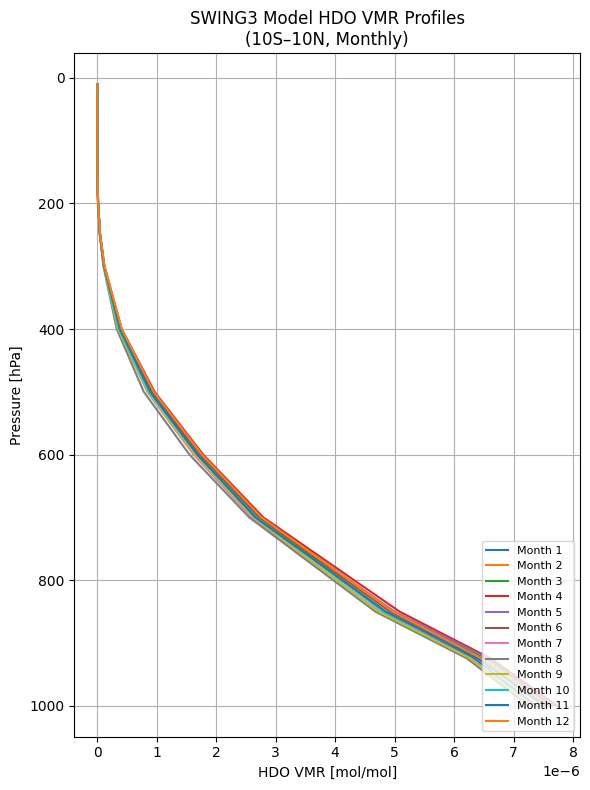

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# === Load SWING3 ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
lon = ds['lon'].values
lat = ds['lat'].values
p = ds['p'].values
dD = ds['dD'].values.astype(float)
q = ds['q'].values.astype(float)

# === Mask fill values ===
dD[dD == -999] = np.nan
q[q == -999] = np.nan

# === Constants ===
Rvsmow = 3.1152e-4
M_air = 28.9647
M_H2O = 18.01528

# === Subset latitude range [-10, 10] and plot all months
lat_mask = (lat >= -10) & (lat <= 10)

plt.figure(figsize=(6, 8))

for m in range(dD.shape[0]):  # assuming shape is (month, level, lat, lon)
    dD_eq = dD[m, :, lat_mask, :]
    q_eq  = q[m, :, lat_mask, :]

    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
    q_mean  = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)

    plt.plot(HDO_vmr1, p, label=f'Month {m+1}')

plt.gca().invert_yaxis()
plt.xlabel('HDO VMR [mol/mol]')
plt.ylabel('Pressure [hPa]')
plt.title('SWING3 Model HDO VMR Profiles\n(10S–10N, Monthly)')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


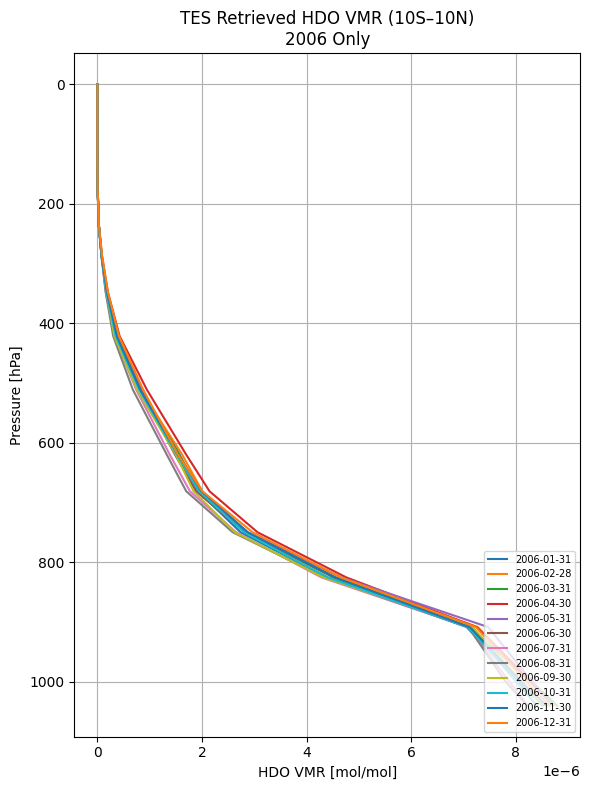

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# === Load TES ===
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")
tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p   = sat['level'].values
tes_time = sat['time'].values

# === Identify indices for 2006 only
if np.issubdtype(tes_time.dtype, np.datetime64):
    time_mask = (tes_time >= np.datetime64('2006-01-01')) & (tes_time <= np.datetime64('2006-12-31'))
else:
    base_date = datetime(2000, 1, 1)
    date_list = [base_date + np.timedelta64(int(t), 'D') for t in tes_time]
    time_mask = [(d.year == 2006) for d in date_list]

valid_indices = np.where(time_mask)[0]

# === Spatial mask
lat_mask = (tes_lat >= -10) & (tes_lat <= 10)

plt.figure(figsize=(6, 8))

for t_tes in valid_indices:
    user_date_str = str(np.datetime_as_string(tes_time[t_tes], unit='D')) if np.issubdtype(tes_time.dtype, np.datetime64) else f"time index {t_tes}"

    HDO_ret = sat['HDO_vmr'].values[t_tes, :, lat_mask, :]
    HDO_ret[HDO_ret == -999] = np.nan
    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)

    plt.plot(HDO_ret_avg, tes_p, label=user_date_str)

plt.gca().invert_yaxis()
plt.xlabel('HDO VMR [mol/mol]')
plt.ylabel('Pressure [hPa]')
plt.title('TES Retrieved HDO VMR (10S–10N)\n2006 Only')
plt.legend(fontsize=7, loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
